In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
diffexp_newmodel_df = pd.read_excel('diffexp_newmodel.xlsx')
common_protein_df = pd.read_excel('lr_protein_common_df.xlsx')

###Import protein-disease association dataframes
#Text Mining Data
disease_tm_df = pd.read_csv('human_disease_textmining_filtered.tsv', sep='\t', header=None)
#Knowledge Data
disease_k_df = pd.read_csv('human_disease_knowledge_filtered.tsv', sep='\t', header=None)
#Experiment Data
disease_e_df = pd.read_csv('human_disease_experiments_filtered.tsv', sep='\t', header=None)

###Import lipid-disease association dataframes
lipidisease_df = pd.read_table('lipidisease_output.tsv',sep='\t')
lipidisease_df = lipidisease_df.rename(columns={'Disease':'disease.name','Lipid':'lipid.name','Lipid_pubchem_cid':'id.pubchem.full','Citations':'lipidisease.citations','p-value':'lipidisease.pval','FDR':'lipidisease.fdr'})
lipidisease_df

,disease.name,lipid.name,id.pubchem.full,lipidisease.citations,lipidisease.pval,lipidisease.fdr
0,Insulin Resistance,Palmitic acid,985,"7752913, 8138059, 9392480, 9805648, 10446195, ...",0.000000e+00,0.000000e+00
1,Obesity,Palmitic acid,985,"1356939, 1864970, 1985095, 2111005, 2552844, 3...",3.273250e-150,1.167941e-149
2,Fatty Liver,Palmitic acid,985,"1640634, 7128823, 9441722, 9799807, 10068949, ...",1.803147e-145,6.368138e-145
3,Non-alcoholic Fatty Liver Disease,Palmitic acid,985,"20014489, 21042596, 21147505, 21206006, 214880...",6.135278e-124,2.070283e-123
4,"Diabetes Mellitus, Type 2",Palmitic acid,985,"1634190, 1666753, 2035624, 8024729, 8257420, 8...",1.715283e-96,5.383524e-96
...,...,...,...,...,...,...
856,Fatigue,"PC(20:4(8Z,11Z,14Z,17Z)/0:0)",53480469,29968805,1.530831e-03,2.372922e-03
857,"Fatigue Syndrome, Chronic",9-Decenoylcarnitine,53481651,29968805,3.552205e-04,5.643585e-04
858,Irritable Bowel Syndrome,9-Decenoylcarnitine,53481651,29968805,3.564287e-04,5.662091e-04
859,Sleep Wake Disorders,9-Decenoylcarnitine,53481651,29968805,7.926008e-04,1.243086e-03


In [3]:
# Extract pubchem ids
for i in diffexp_newmodel_df[diffexp_newmodel_df['id.pubchem.full'].notna()]['id.pubchem.full']:
    if ',' in i:
        sep = i.split(',')
        for j in sep:
            print(j)
    else:
        print(i)

3247037
5282777
21774059
12268269
13132095
52921769
92033282
10471
52921746
5312326
52921745
20245
21774057
5282776
5312580
100966706
12268267
5312582
9543632
52921768
5312581
101143232
5312579
5312341
100966704
5282613
52921866
46176643
5312334
5312397
5312718
5312720
5312722
5312717
5312396
5312725
5312724
1575608
5312721
54596240
5312719
5312723
5282775
14215561
5312572
5312571
44176401
131839763
14215564
85896840
24770810
131839766
21774056
5282774
6441476
5282610
10470
52921744
5312729
5312370
5634
5312371
74409
5282728
5312728
5282669
5312373
11206201
517344
5312372
71362946
11286864
5312726
5312369
5282670
5312727
7714
52924053
52921767
5312569
100966702
21774058
5312567
5312570
5312568
57388420
131839762
5312564
5312561
92033120
5312562
5312563
543855
5312565
23524
52921743
5282609
5282675
5282674
11823531
139265371
129724961
5312547
52921861
6440260
5282773
5281120
129313357
22401641
87065709
14178785
92033129
21774055
56936051
14178786
71402234
5282608
5282606
10469
52921728


In [4]:
#Rename columns of each dataframe for clarity
disease_tm_df = disease_tm_df.rename(columns={0:'id.string', 1:'gene.name', 2:'disease.id', 3:'disease.name',4:'zscore',5:'confidence',6:'url'})
disease_k_df = disease_k_df.rename(columns={0:'id.string', 1:'gene.name', 2:'disease.id', 3:'disease.name',4:'source.db',5:'evidence.type',6:'confidence'})
disease_e_df = disease_e_df.rename(columns={0:'id.string', 1:'gene.name', 2:'disease.id', 3:'disease.name',4:'source.db',5:'source.score',6:'confidence'})

In [5]:
# Retrieve analyte name from uniprot id
def get_name_from_uniprot_id(accession):
    if not accession:  # Check if the accession is empty or None
        return 'invalid accession' # or return '' if you prefer an empty string
    try:
        response = requests.get(f"https://rest.uniprot.org/uniprotkb/{accession}.json")
        if response and response.status_code == 200:
            data = response.json()
            if 'uniProtkbId' in data:
                return data.get('uniProtkbId')
        else:
            return "Error: Response not successful"
    except requests.exceptions.RequestException as e:
        return f"Error: {e}"

# Retrieve string protein id from uniprot id
def get_string_from_uniprot_id(accession):
    if not accession:  # Check if the accession is empty or None
        return 'i' # or return '' if you prefer an empty string
    try:
        response = requests.get(f"https://rest.uniprot.org/uniprotkb/{accession}.json")
        if response and response.status_code == 200:
            data = response.json()
            if 'uniProtKBCrossReferences' in data:
                uniprot_crossref =  data.get('uniProtKBCrossReferences')
                for i in uniprot_crossref:
                    if i.get('database') == 'STRING':
                        string_id = i.get('id')
                        string_id = string_id.split('.')[1]
                        print(string_id)
                        return string_id
        else:
            return ''
    except requests.exceptions.RequestException as e:
        return ''

# Retrieve disease associations from uniprot
def get_uniprot_disease(accession):
    if not accession:  # Check if the accession is empty or None
        return 'invalid accession' # or return '' if you prefer an empty string
    try:
        response = requests.get(f"https://rest.uniprot.org/uniprotkb/{accession}.json")
        if response and response.status_code == 200:
            output = []
            data = response.json()
            protein_desc = data.get('proteinDescription').get('recommendedName')
            protein_full_name = protein_desc.get('fullName').get('value') if protein_desc else ''
            if 'comments' in data:
                protein_name = data.get('uniProtkbId')
                protein_id = data.get('primaryAccession')
                for comment in data['comments']:
                    if comment.get('commentType') == 'DISEASE':
                        disease_info = comment.get('disease')
                        if disease_info:
                            id = disease_info.get('diseaseId')
                            acro = disease_info.get('acronym')
                            desc = disease_info.get('description')
                            evidence = disease_info.get('evidences')
                            ev_ids = []
                            if disease_info.get('evidences'):
                                for ev in evidence:
                                    source = ev.get('source')
                                    source_id = ev.get('id')
                                    ev_ids.append(f'{source} ID: {source_id}')
                            output.append({'id.name':protein_name, 'id.full':protein_full_name,'id.uniprot':protein_id, 'disease.name':id, 'disease.acronym':acro,'disease.description':desc,'disease.evidence':ev_ids})
                return output
        else:
            return "Error: Response not successful"
    except requests.exceptions.RequestException as e:
        return f"Error: {e}"

# Retrieve GO annotations from uniprot id
def get_go_annotations(accession):
    if not accession:  # Check if the accession is empty or None
        return 'invalid accession' # or return '' if you prefer an empty string
    try:
        uniprot_name = get_name_from_uniprot_id(accession)
        response = requests.get(f"https://www.ebi.ac.uk/QuickGO/services/annotation/search?taxonId=9606&geneProductId={accession}")
        if response and response.status_code == 200:
            output = []
            data = response.json()
            if 'results' in data:
                for result in data['results']:
                    ref = result.get('reference')
                    goid = result.get('goId')
                    qual = result.get('qualifier')
                    goid_desc = get_goid_name(goid)
                    output.append({'id.name':uniprot_name,'id.uniprot':accession,'goID':goid,'qualifier':qual,'reference.id':ref,'function.name':goid_desc[0]['function.name'],'function.definition':goid_desc[0]['function.definition']})
                return output
        else:
            return "Error: Response not successful"
    except requests.exceptions.RequestException as e:
        return f"Error: {e}"


# Retrieve GOID name from go id
def get_goid_name(goid):
    if not goid:  # Check if the accession is empty or None
        return 'invalid accession' # or return '' if you prefer an empty string
    try:
        goid_new = goid.replace(':','%3A')
        response = requests.get(f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{goid_new}")
        if response and response.status_code == 200:
            data = response.json()
            if 'results' in data:
                for result in data['results']:
                    if result.get('id') == goid:
                        name = result.get('name')
                        definition = ''
                        if 'definition' in result:
                            output = []
                            definition = result.get('definition').get('text')
                            output.append({'goID': goid, 'function.name': name, 'function.definition': definition})
                            return output
        else:
            return "Error: Response not successful"
    except requests.exceptions.RequestException as e:
        return f"Error: {e}"


In [6]:
lipid_dgc_df = diffexp_newmodel_df[(diffexp_newmodel_df['lm1.groupDMEK.bh.pval']<0.01)&(diffexp_newmodel_df['lm1.groupDG.bh.pval']<0.01)&(diffexp_newmodel_df['id.type']=='lipid')].copy()

# Convert 'id.pubchem.full' to string and apply string methods in both DataFrames
lipid_dgc_df['id.pubchem.full'] = lipid_dgc_df['id.pubchem.full'].astype(str).str.strip().str.lower()
lipidisease_df['id.pubchem.full'] = lipidisease_df['id.pubchem.full'].astype(str).str.strip().str.lower()

# Initialize an empty list to store the lipid information
lipids = []

# Iterate through each row of the DataFrame
for index, row in lipid_dgc_df.iterrows():
    # Split the 'id.pubchem.full' by comma if necessary
    pubchem_ids = row['id.pubchem.full'].split(',') if ',' in row['id.pubchem.full'] else [row['id.pubchem.full']]

    # For each pubchem ID, create a dictionary with the lipid information
    for pubchem_id in pubchem_ids:
        lipid_info = {
            'id.pubchem.full': pubchem_id.strip().lower(),  # Ensure ID is stripped and lowercase
            'id.name': row['id.name'],
            'id.description': row['id.description'],
            'lm1.groupDMEK.bh.pval': row['lm1.groupDMEK.bh.pval'],
            'lm1.groupDMEK.coef': row['lm1.groupDMEK.coef'],
            'lm1.groupDG.bh.pval': row['lm1.groupDG.bh.pval'],
            'lm1.groupDG.coef': row['lm1.groupDG.coef'],
            'lm1.groupDGC.holm.pval': row['lm1.groupDGC.holm.pval'],
            'lm1.groupDGC.coef': row['lm1.groupDGC.coef']
        }
        lipids.append(lipid_info)

# Convert the list of dictionaries to a DataFrame
lipid_df = pd.DataFrame(lipids)
# Filter lipidisease_df for matching entries
lipid_common_df = lipidisease_df[lipidisease_df['id.pubchem.full'].isin(lipids[0])]
lipid_merged_df = lipidisease_df.merge(lipid_df,how='right',on='id.pubchem.full')
lipid_merged_df = lipid_merged_df[lipid_merged_df['lipidisease.citations'].notna()]
lipid_merged_df.to_excel('lipidisease_assocations.xlsx',index=False)

In [7]:
diffexp_newmodel_df['id.string'] = diffexp_newmodel_df['id.uniprot'].apply(get_string_from_uniprot_id)
diffexp_newmodel_df.to_excel('diffexp_newmodel.xlsx',index=False)

ENSP00000362924
ENSP00000356191
ENSP00000236671
ENSP00000237014
ENSP00000386104
ENSP00000309096
ENSP00000216492
ENSP00000376678
ENSP00000377783
ENSP00000227667
ENSP00000378401
ENSP00000378131
ENSP00000301464
ENSP00000498697
ENSP00000295633
ENSP00000284981
ENSP00000381448
ENSP00000351682
ENSP00000463151
ENSP00000373477
ENSP00000466775
ENSP00000358777
ENSP00000339730
ENSP00000269141
ENSP00000485478
ENSP00000266041
ENSP00000366513
ENSP00000358966
ENSP00000495530
ENSP00000385519
ENSP00000498441
ENSP00000359629
ENSP00000497691
ENSP00000236850
ENSP00000266546
ENSP00000370010
ENSP00000364782
ENSP00000416126
ENSP00000360687
ENSP00000261590
ENSP00000460236
ENSP00000193391
ENSP00000233242
ENSP00000273784
ENSP00000414856
ENSP00000295897
ENSP00000385035
ENSP00000384906
ENSP00000493985
ENSP00000254722
ENSP00000257867
ENSP00000220763
ENSP00000378517
ENSP00000406773
ENSP00000433112
ENSP00000266719
ENSP00000410815
ENSP00000332613
ENSP00000417138
ENSP00000451172
ENSP00000215912
ENSP00000354458
ENSP0000

In [8]:
# Extract list of all pvalues and coefficients of proteins with string id
dgc_df = diffexp_newmodel_df[(diffexp_newmodel_df['lm1.groupDG.bh.pval']<0.01)&(diffexp_newmodel_df['lm1.groupDMEK.bh.pval']<0.01)&(diffexp_newmodel_df['id.type']=='protein')].copy()
string_ids = {
    'id.string':dgc_df['id.string'].tolist(),
    'lm1.groupDGC.holm.pval':dgc_df['lm1.groupDGC.holm.pval'].tolist(),
    'lm1.groupDGC.bh.pval':dgc_df['lm1.groupDGC.bh.pval'].tolist(),
    'lm1.groupDGC.coef':dgc_df['lm1.groupDGC.coef'].tolist(),
    'lm1.groupDMEK.holm.pval':dgc_df['lm1.groupDMEK.holm.pval'].tolist(),
    'lm1.groupDMEK.bh.pval':dgc_df['lm1.groupDMEK.bh.pval'].tolist(),
    'lm1.groupDMEK.coef':dgc_df['lm1.groupDMEK.coef'].tolist(),
    'lm1.groupDG.holm.pval':dgc_df['lm1.groupDG.holm.pval'].tolist(),
    'lm1.groupDG.bh.pval':dgc_df['lm1.groupDG.bh.pval'].tolist(),
    'lm1.groupDG.coef':dgc_df['lm1.groupDG.coef'].tolist(),
    'id.uniprot':dgc_df['id.uniprot'].tolist(),
    'id.name':dgc_df['id.name'].tolist()
}

string_ids_df = pd.DataFrame(string_ids,index=None)

# organize disease associations by evidence
disease_dgc_tm_df = disease_tm_df[disease_tm_df['id.string'].isin(string_ids['id.string'])]
disease_dgc_tm_df = disease_dgc_tm_df.assign(channel = 'TM')
disease_dgc_tm_merged_df = disease_dgc_tm_df.merge(string_ids_df,how='right',on='id.string')

disease_dgc_k_df = disease_k_df[disease_k_df['id.string'].isin(string_ids['id.string'])]
disease_dgc_k_df = disease_dgc_k_df.assign(channel = 'K')
disease_dgc_k_merged_df = disease_dgc_k_df.merge(string_ids_df,how='right',on='id.string')

disease_dgc_e_df = disease_e_df[disease_e_df['id.string'].isin(string_ids['id.string'])]
disease_dgc_e_df = disease_dgc_e_df.assign(channel = 'E')
disease_dgc_e_merged_df = disease_dgc_e_df.merge(string_ids_df,how='right',on='id.string')

disease_dgc_all_df = pd.concat([disease_dgc_tm_df,disease_dgc_k_df,disease_dgc_e_df])
disease_dgc_all_merged_df = disease_dgc_all_df.merge(string_ids_df,how='right',on='id.string')

print(len(disease_dgc_tm_merged_df))
print(len(disease_dgc_k_merged_df))
print(len(disease_dgc_e_merged_df))
print(len(disease_dgc_all_df))

disease_dgc_all_merged_df.to_excel('disease_dgc_all.xlsx',index=False)
sorted_disease_df = disease_dgc_all_merged_df.sort_values('lm1.groupDGC.coef',ascending=False)
sorted_disease_df.to_excel('disease_dgc_all_sorted.xlsx', index=False)
print(len(disease_dgc_all_merged_df['id.string'].unique()))

1721
89
67
1842
36


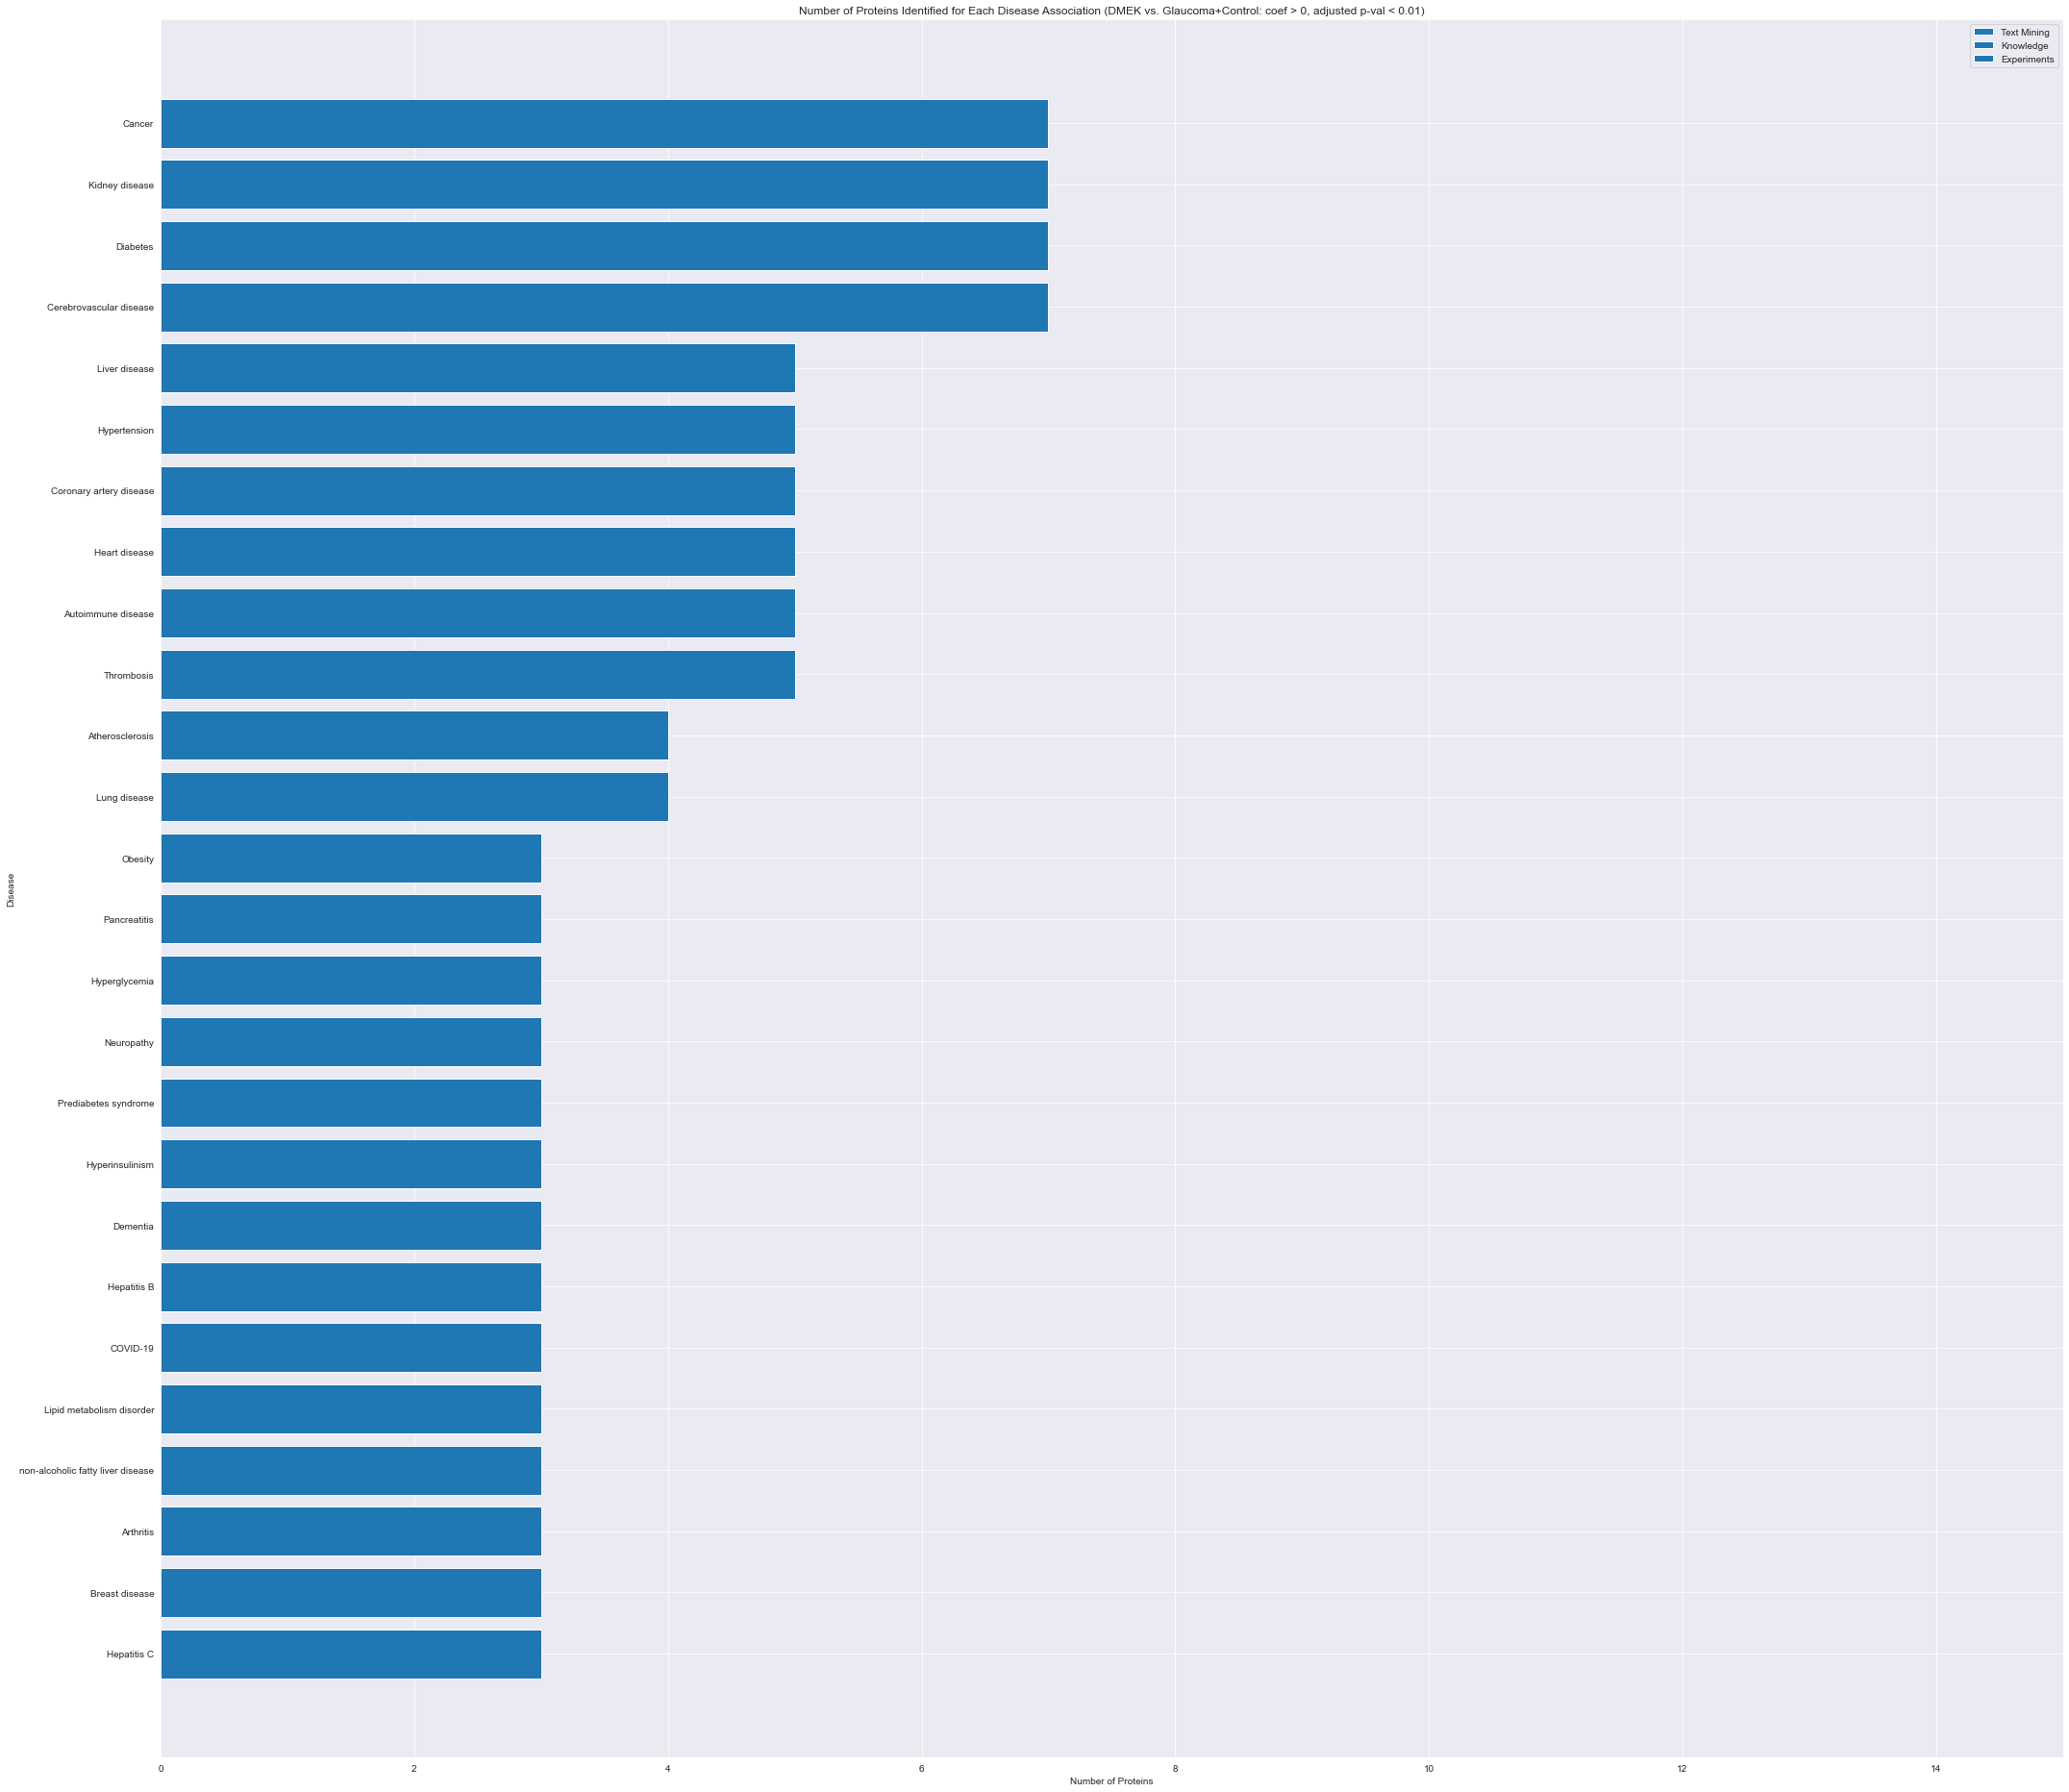

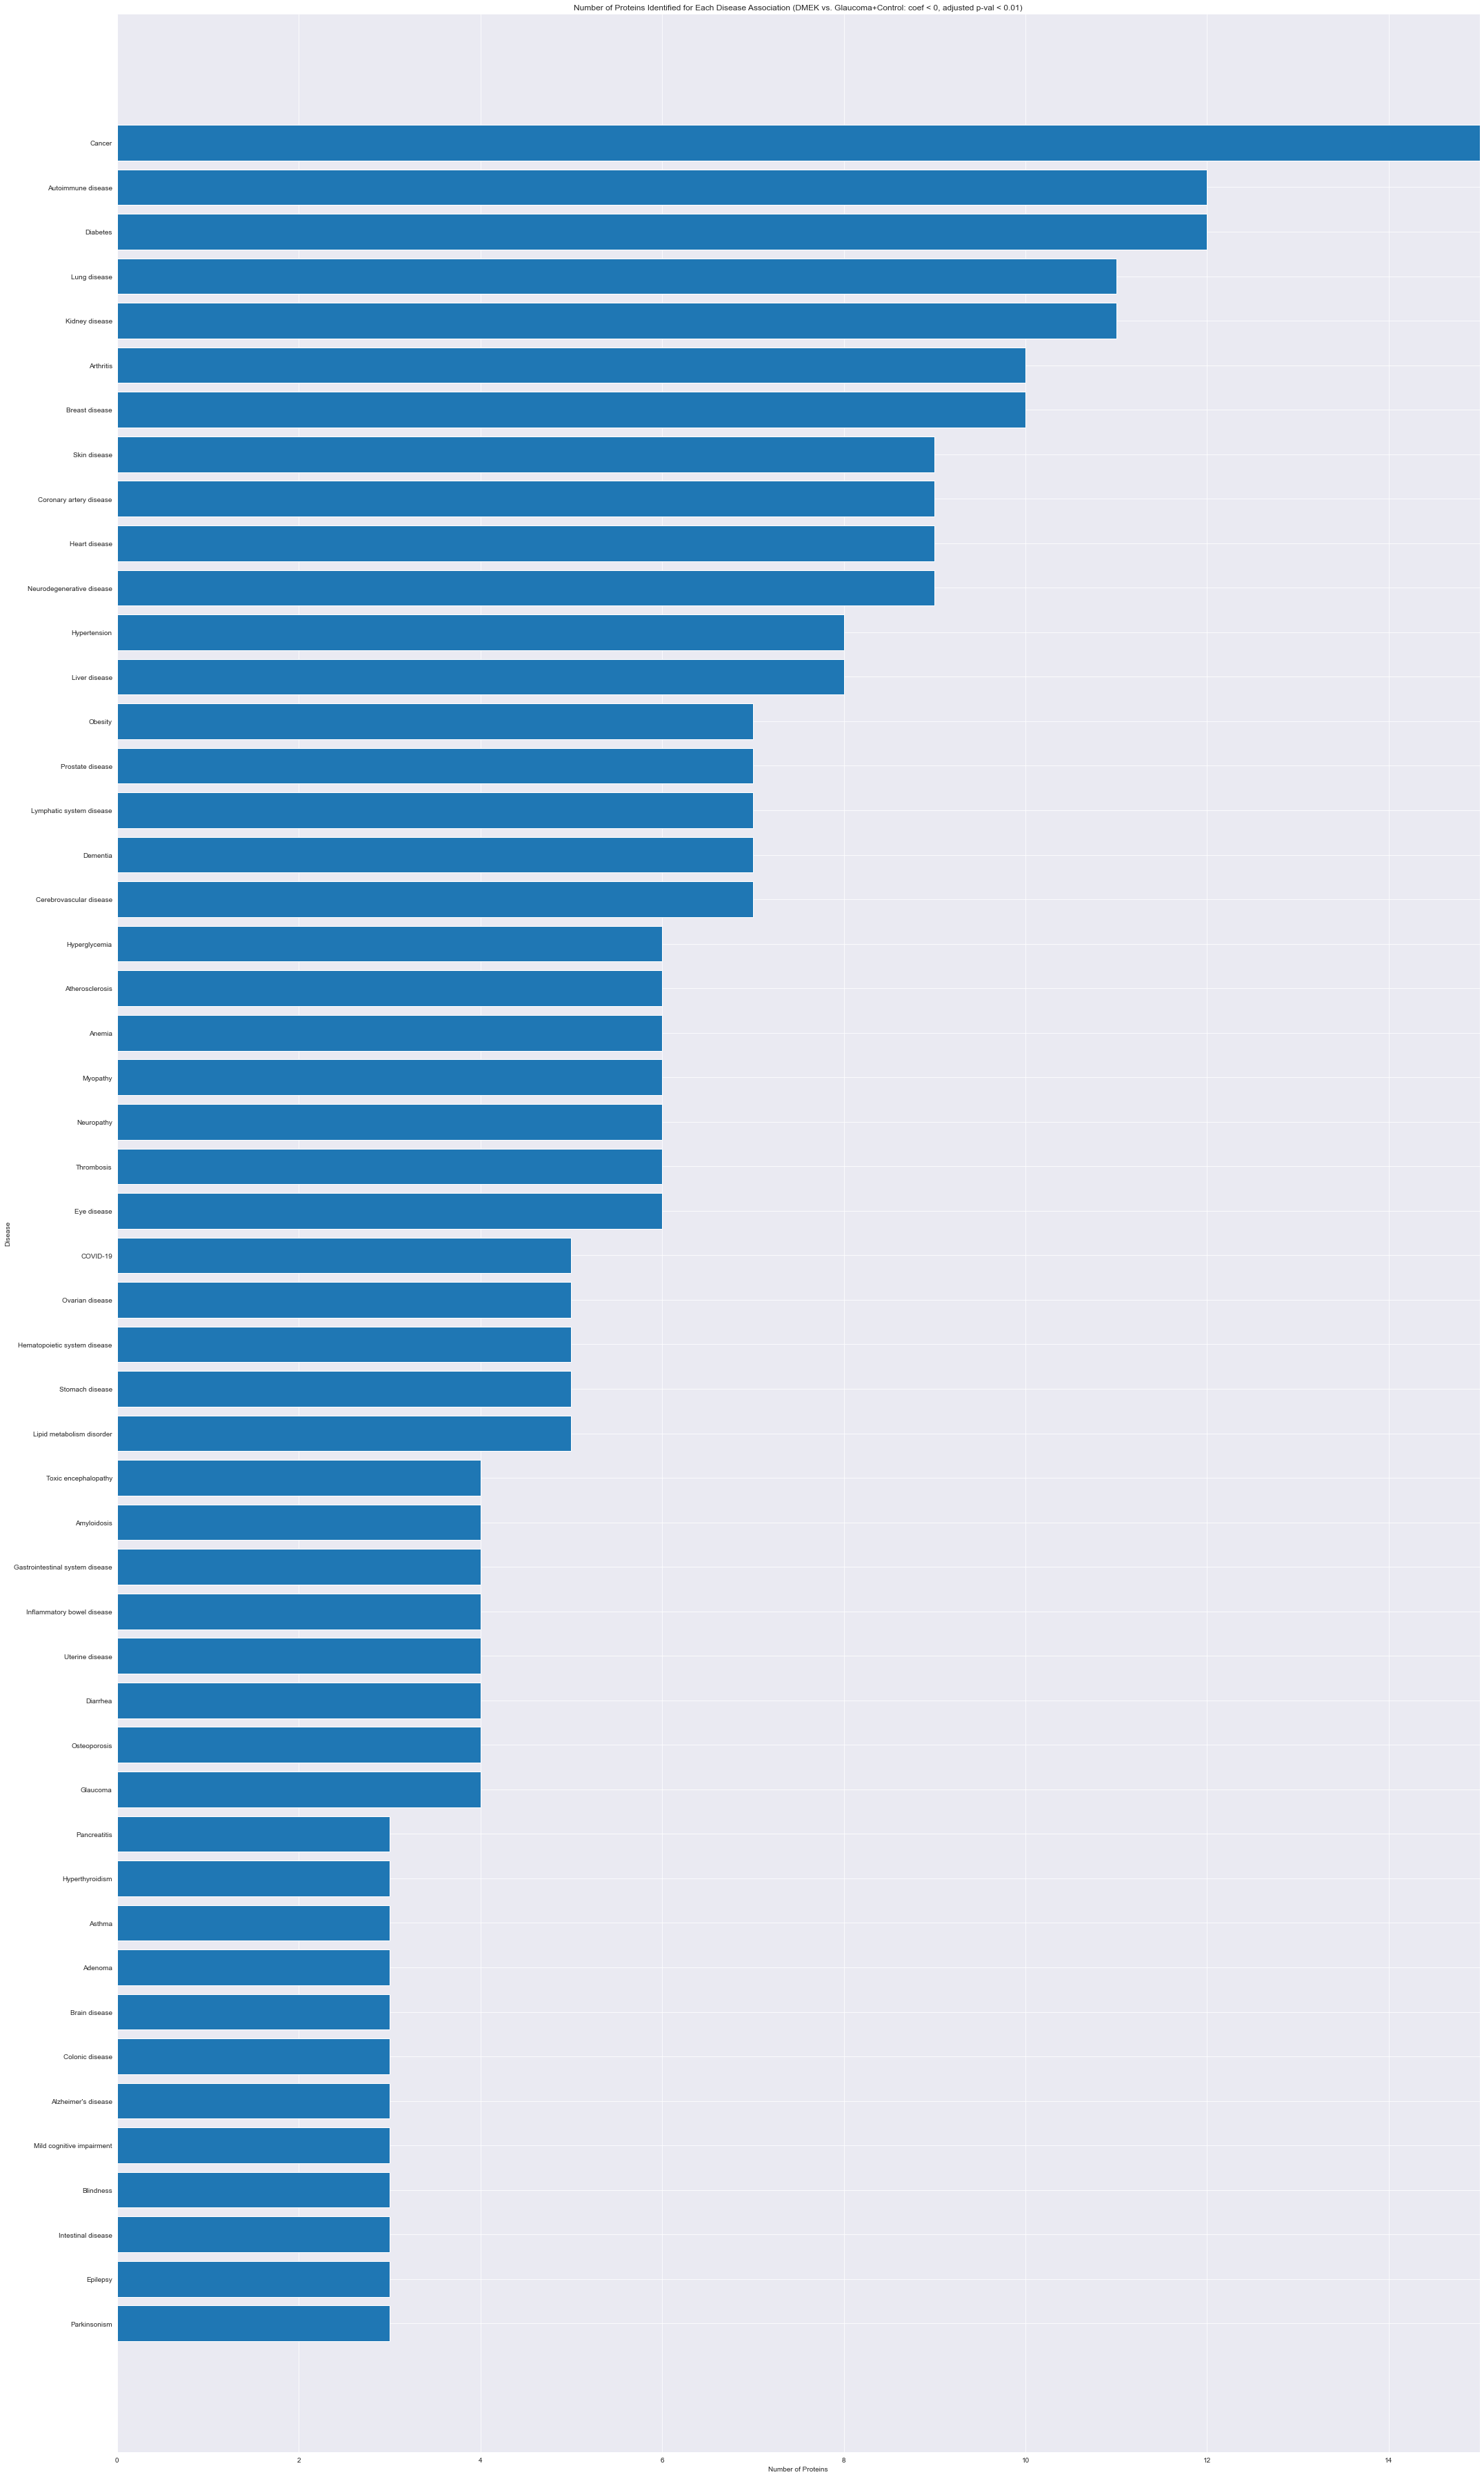

In [9]:
# plot all number of disease associations

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

plt.rc('font', size=22)
figwidth = 30
scalar = .7
pad = 10
counts = 2
rcParams.update({'figure.autolayout': True})

diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']>0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'TM')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

max_length = len(disease_all_plot_filtered_df)

dynamic_scalar = max_length / 1

fig, ax = plt.subplots(figsize=(figwidth,dynamic_scalar))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([0,15])
plt.title('Number of Proteins Identified for Each Disease Association (DMEK vs. Glaucoma+Control: coef > 0, adjusted p-val < 0.01)')
plt.xlabel('Number of Proteins')
plt.ylabel('Disease')

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()

diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']>0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'K')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()

diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']>0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'E')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()
plt.legend(['Text Mining','Knowledge','Experiments'])
plt.savefig('disease_dgc_g0.png')
plt.tight_layout()
plt.show()

######
diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']<0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'TM')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

max_length = len(disease_all_plot_filtered_df)

dynamic_scalar = max_length / 1

fig, ax = plt.subplots(figsize=(figwidth,dynamic_scalar))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([0,15])
plt.title('Number of Proteins Identified for Each Disease Association (DMEK vs. Glaucoma+Control: coef < 0, adjusted p-val < 0.01)')
plt.xlabel('Number of Proteins')
plt.ylabel('Disease')

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()

diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']>0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'K')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()

diseases = disease_dgc_all_merged_df[(disease_dgc_all_merged_df['lm1.groupDGC.coef']>0)&(disease_dgc_all_merged_df['confidence']>2)&(disease_dgc_all_merged_df['channel'] == 'E')]['disease.name'].value_counts()
disease_all_plot_df = pd.DataFrame(diseases).reset_index()
disease_all_plot_df.columns = ['disease.name', 'count']  # Renaming columns for clarity
disease_all_plot_filtered_df = disease_all_plot_df[disease_all_plot_df['count'] > counts]

x = disease_all_plot_filtered_df['disease.name']
y = disease_all_plot_filtered_df['count']
ax.barh(x, width = y)
ax.invert_yaxis()
plt.savefig('disease_dgc_l0.png')
plt.tight_layout()
plt.show()

In [10]:
disease_dgc_all_merged_df.to_excel('protein_disease_associations.xlsx',index=False)

In [11]:
pd.DataFrame(get_uniprot_disease('P02647'))

,id.name,id.full,id.uniprot,disease.name,disease.acronym,disease.description,disease.evidence
0,APOA1_HUMAN,Apolipoprotein A-I,P02647,"Hypoalphalipoproteinemia, primary, 2",FHA2,An autosomal recessive disorder of lipoprotein...,"[PubMed ID: 1898657, PubMed ID: 1901417, PubMe..."
1,APOA1_HUMAN,Apolipoprotein A-I,P02647,"Hypoalphalipoproteinemia, primary, 2, intermed...",FHA2I,An autosomal dominant disorder of lipoprotein ...,[PubMed ID: 8240372]
2,APOA1_HUMAN,Apolipoprotein A-I,P02647,Amyloidosis 8,AMYL8,A form of hereditary generalized amyloidosis. ...,"[PubMed ID: 10198255, PubMed ID: 10487826, Pub..."
3,APOA1_HUMAN,Apolipoprotein A-I,P02647,Familial apolipoprotein gene cluster deletion ...,FAPLDS,An autosomal dominant disorder of lipoprotein ...,[PubMed ID: 6800349]


In [12]:
protein_disease = []
protein_df = diffexp_newmodel_df[diffexp_newmodel_df['id.uniprot'].notnull()]
uniprot_ids = protein_df['id.uniprot'].tolist()

for i in uniprot_ids:
    print(i)
    protein_disease.extend(get_uniprot_disease(i))

P06396
Q9UBM4
P07339
P02766
P16870
O43505
P10645
Q01995
P07225
P02656
Q08629
P05156
P24592
Q8IZJ3
Q12841
P05067
P01034
Q96KN2
P10745
P22352
P02655
Q15904
P35443
P19022
Q96JP9
Q14624
O94985
Q17R60
P06733
P08571
P02671
Q9NQ79
Q06481
P02647
Q9BQT9
P62328
Q99519
Q96NZ9
P41222
Q14126
Q9HCB6
Q9BZV3
P04114
P02765
Q14515
P02768
P09871
P0DJI8
P01042
P36955
Q9GZZ8
Q9Y646
P10451
P81605
Q9UBP4
O60938
B4E1Z4
Q86UD1
P55058
P29622
Q96FE7
P07357
P02511
P0DP23
Q9Y5W5
Q16610
P59665
P12109
P14618
P00760
Q14574
Q86UX2
Q8NBJ4
Q14767
Q9UHG2
Q15582
P01160
P40967
P78509
P15291
P51884
P08697
Q16661
P06727
P09486
P39060
P00450
Q14393
P02489
P68104
P51888
P01023
P08670
P04196
P98160
P02652
Q02818
P05408
Q9HCQ7
P53674
P01031
A0A0B4J1X5
P02787
Q08174
A0A096LPE2
O43491
P33908
Q8IUX7
Q5FWE3
O14791
O00461
O60664
Q12797
Q9BRK5
P0C0L4
P04264
P05813
A0A494C0G5
P02748
P19823
O15354
P01008
P05060
P00736
P53673
P13647
P60709
O00391
Q86X29
P24593
Q9UN70
A0A0G2JPD3
P16519
P01011
Q9Y240
Q14112
P52565
Q8N475
P35555
P49257
Q8WX

In [13]:
protein_function = []
uniprot_ids = common_protein_df['id.uniprot'].tolist()

for i in uniprot_ids:
    print(i)
    protein_function.extend(get_go_annotations(i))

P06396
P07339
P02766
P16870
O43505
P10645
Q01995
Q08629
Q12841
Q96KN2
P06733
P08571
P62328
P04114
Q9GZZ8
Q14767


In [14]:
protein_disease_df = pd.DataFrame(protein_disease)
protein_disease_df
protein_disease_df.to_excel('protein_disease.xlsx', index=False)

In [15]:
protein_function_df = pd.DataFrame(protein_function)
protein_function_df

,id.name,id.uniprot,goID,qualifier,reference.id,function.name,function.definition
0,GELS_HUMAN,P06396,GO:0022617,NOT|involved_in,PMID:24236012,extracellular matrix disassembly,A process that results in the breakdown of the...
1,GELS_HUMAN,P06396,GO:0005634,colocalizes_with,PMID:23729654,nucleus,A membrane-bounded organelle of eukaryotic cel...
2,GELS_HUMAN,P06396,GO:0030864,colocalizes_with,PMID:23575248,cortical actin cytoskeleton,"The portion of the actin cytoskeleton, compris..."
3,GELS_HUMAN,P06396,GO:0003779,enables,GO_REF:0000043,actin binding,Binding to monomeric or multimeric forms of ac...
4,GELS_HUMAN,P06396,GO:0003779,enables,PMID:18266911,actin binding,Binding to monomeric or multimeric forms of ac...
...,...,...,...,...,...,...,...
364,LTBP2_HUMAN,Q14767,GO:0031012,located_in,PMID:7798248,extracellular matrix,A structure lying external to one or more cell...
365,LTBP2_HUMAN,Q14767,GO:0062023,located_in,PMID:27559042,collagen-containing extracellular matrix,An extracellular matrix consisting mainly of p...
366,LTBP2_HUMAN,Q14767,GO:0062023,located_in,PMID:28327460,collagen-containing extracellular matrix,An extracellular matrix consisting mainly of p...
367,LTBP2_HUMAN,Q14767,GO:0070062,located_in,PMID:21362503,extracellular exosome,A vesicle that is released into the extracellu...


In [16]:
# Export protein functions

def make_clickable(val):
    # Check if the value is a string to avoid errors
    if isinstance(val, str):
        if 'PMID:' in val:
            return f'https://europepmc.org/article/MED/{val.split(":")[1]}'
        elif 'GO_REF:' in val:
            return f'https://github.com/geneontology/go-site/blob/master/metadata/gorefs/goref-{val.split(":")[1]}.md'
        elif 'Reactome:' in val:
            return f'https://www.reactome.org/content/detail/{val.split(":")[1]}'
    # Return the original value if it doesn't match the conditions
    return val

def hyperlink(val):
    url = make_clickable(val)
    return f'=HYPERLINK("{url}","{val}")'

# Apply the make_clickable function to the 'reference.id.url' column for display
protein_function_df['reference.id.url'] = protein_function_df['reference.id'].apply(hyperlink)

coefs = []
for ids in protein_function_df['id.name']:
    print(common_protein_df[common_protein_df['id.name'] == ids]['lr.DMEK.coef'].item())
    coefs.append(common_protein_df[common_protein_df['id.name'] == ids]['lr.DMEK.coef'].item())

protein_function_df['lr.DMEK.coef'] = coefs

protein_function_df

-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1620897222708919
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557
-0.1716740348357557


,id.name,id.uniprot,goID,qualifier,reference.id,function.name,function.definition,reference.id.url,lr.DMEK.coef
0,GELS_HUMAN,P06396,GO:0022617,NOT|involved_in,PMID:24236012,extracellular matrix disassembly,A process that results in the breakdown of the...,"=HYPERLINK(""https://europepmc.org/article/MED/...",-0.16209
1,GELS_HUMAN,P06396,GO:0005634,colocalizes_with,PMID:23729654,nucleus,A membrane-bounded organelle of eukaryotic cel...,"=HYPERLINK(""https://europepmc.org/article/MED/...",-0.16209
2,GELS_HUMAN,P06396,GO:0030864,colocalizes_with,PMID:23575248,cortical actin cytoskeleton,"The portion of the actin cytoskeleton, compris...","=HYPERLINK(""https://europepmc.org/article/MED/...",-0.16209
3,GELS_HUMAN,P06396,GO:0003779,enables,GO_REF:0000043,actin binding,Binding to monomeric or multimeric forms of ac...,"=HYPERLINK(""https://github.com/geneontology/go...",-0.16209
4,GELS_HUMAN,P06396,GO:0003779,enables,PMID:18266911,actin binding,Binding to monomeric or multimeric forms of ac...,"=HYPERLINK(""https://europepmc.org/article/MED/...",-0.16209
...,...,...,...,...,...,...,...,...,...
364,LTBP2_HUMAN,Q14767,GO:0031012,located_in,PMID:7798248,extracellular matrix,A structure lying external to one or more cell...,"=HYPERLINK(""https://europepmc.org/article/MED/...",0.26905
365,LTBP2_HUMAN,Q14767,GO:0062023,located_in,PMID:27559042,collagen-containing extracellular matrix,An extracellular matrix consisting mainly of p...,"=HYPERLINK(""https://europepmc.org/article/MED/...",0.26905
366,LTBP2_HUMAN,Q14767,GO:0062023,located_in,PMID:28327460,collagen-containing extracellular matrix,An extracellular matrix consisting mainly of p...,"=HYPERLINK(""https://europepmc.org/article/MED/...",0.26905
367,LTBP2_HUMAN,Q14767,GO:0070062,located_in,PMID:21362503,extracellular exosome,A vesicle that is released into the extracellu...,"=HYPERLINK(""https://europepmc.org/article/MED/...",0.26905


In [17]:
protein_function_df.to_excel('protein_function.xlsx', index=False)
protein_function_df.sort_values('lr.DMEK.coef',ascending=False).to_excel('protein_function_sorted.xlsx', index=False)

In [20]:
# Retrieve all go annotations
protein_DGC_function = []
uniprot_ids = diffexp_newmodel_df[(diffexp_newmodel_df['lm1.groupDGC.holm.pval']<0.01)&(diffexp_newmodel_df['id.type']=='protein')]['id.uniprot'].tolist()

for i in uniprot_ids:
    print(i)
    protein_DGC_function.extend(get_go_annotations(i))

P06396
Q9UBM4
P07339
P02766
P16870
O43505
P10645
Q01995
P07225
P02656
Q08629
P05156
P24592
Q8IZJ3
Q12841
P05067
P01034
Q96KN2
P10745
P22352
Q15904
P35443
P19022
Q96JP9
Q14624
O94985
Q17R60
P06733
P08571
P02671
Q9NQ79
Q06481
P02647
Q9BQT9
Q99519
Q96NZ9
Q9HCB6
P04114
Q14515
Q9GZZ8


In [22]:
protein_DGC_function_df = pd.DataFrame(protein_DGC_function)
protein_DGC_function_df.to_excel('protein_DGC_function.xlsx',index=False)

In [23]:
protein_DGC_function_df = pd.read_excel('protein_DGC_function.xlsx')

coefs = []
pvals = []
for ids in protein_DGC_function_df['id.name']:
    coefs.append(diffexp_newmodel_df[diffexp_newmodel_df['id.name'] == ids]['lm1.groupDGC.coef'].item())
    pvals.append(diffexp_newmodel_df[diffexp_newmodel_df['id.name'] == ids]['lm1.groupDGC.holm.pval'].item())

protein_DGC_function_df['lm1.groupDGC.coef'] = coefs
protein_DGC_function_df['lm1.groupDGC.holm.pval'] = pvals
protein_DGC_function_df['reference.id.url'] = protein_DGC_function_df['reference.id'].apply(hyperlink)


protein_DGC_function_df.to_excel('protein_function.xlsx',index=False)

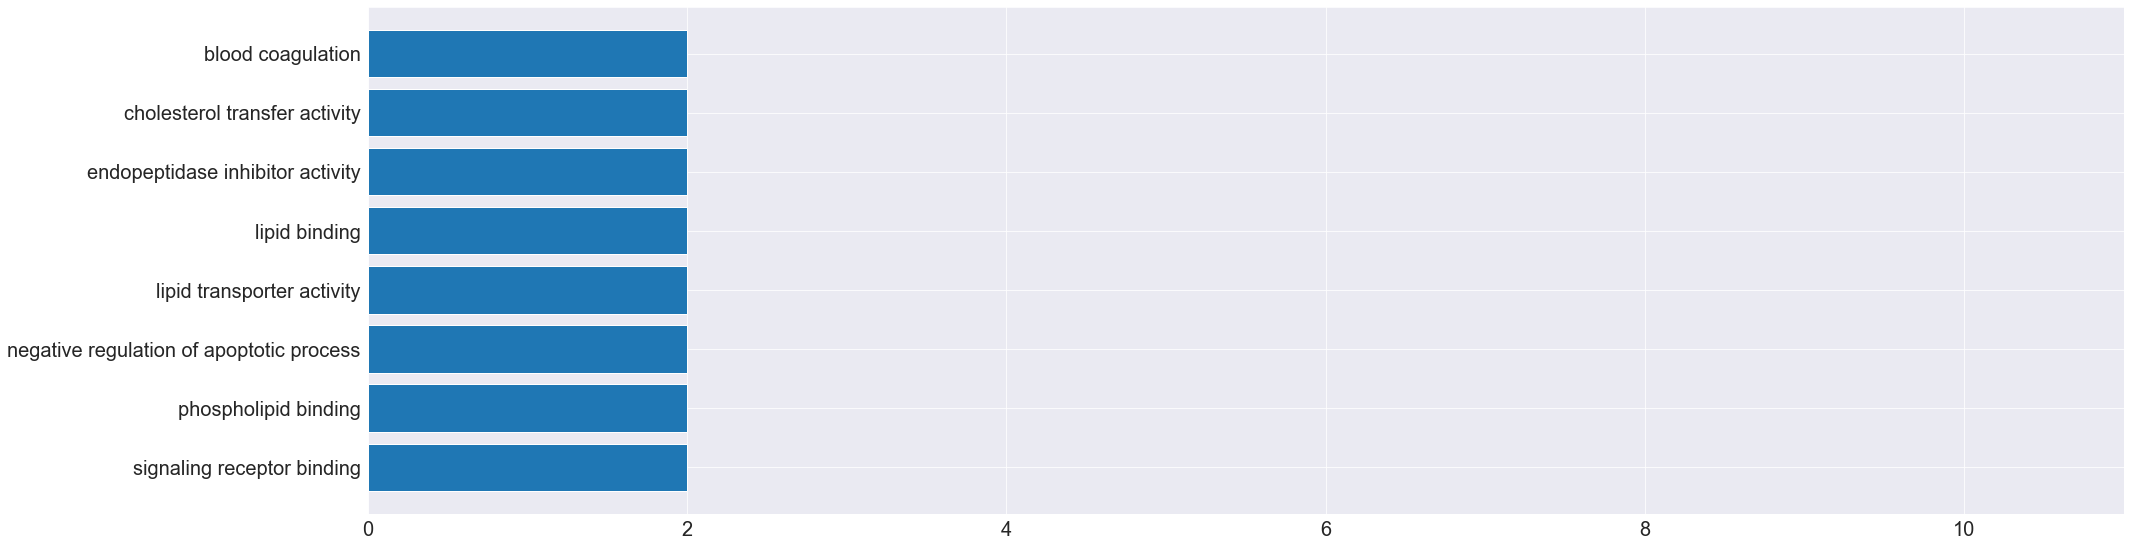

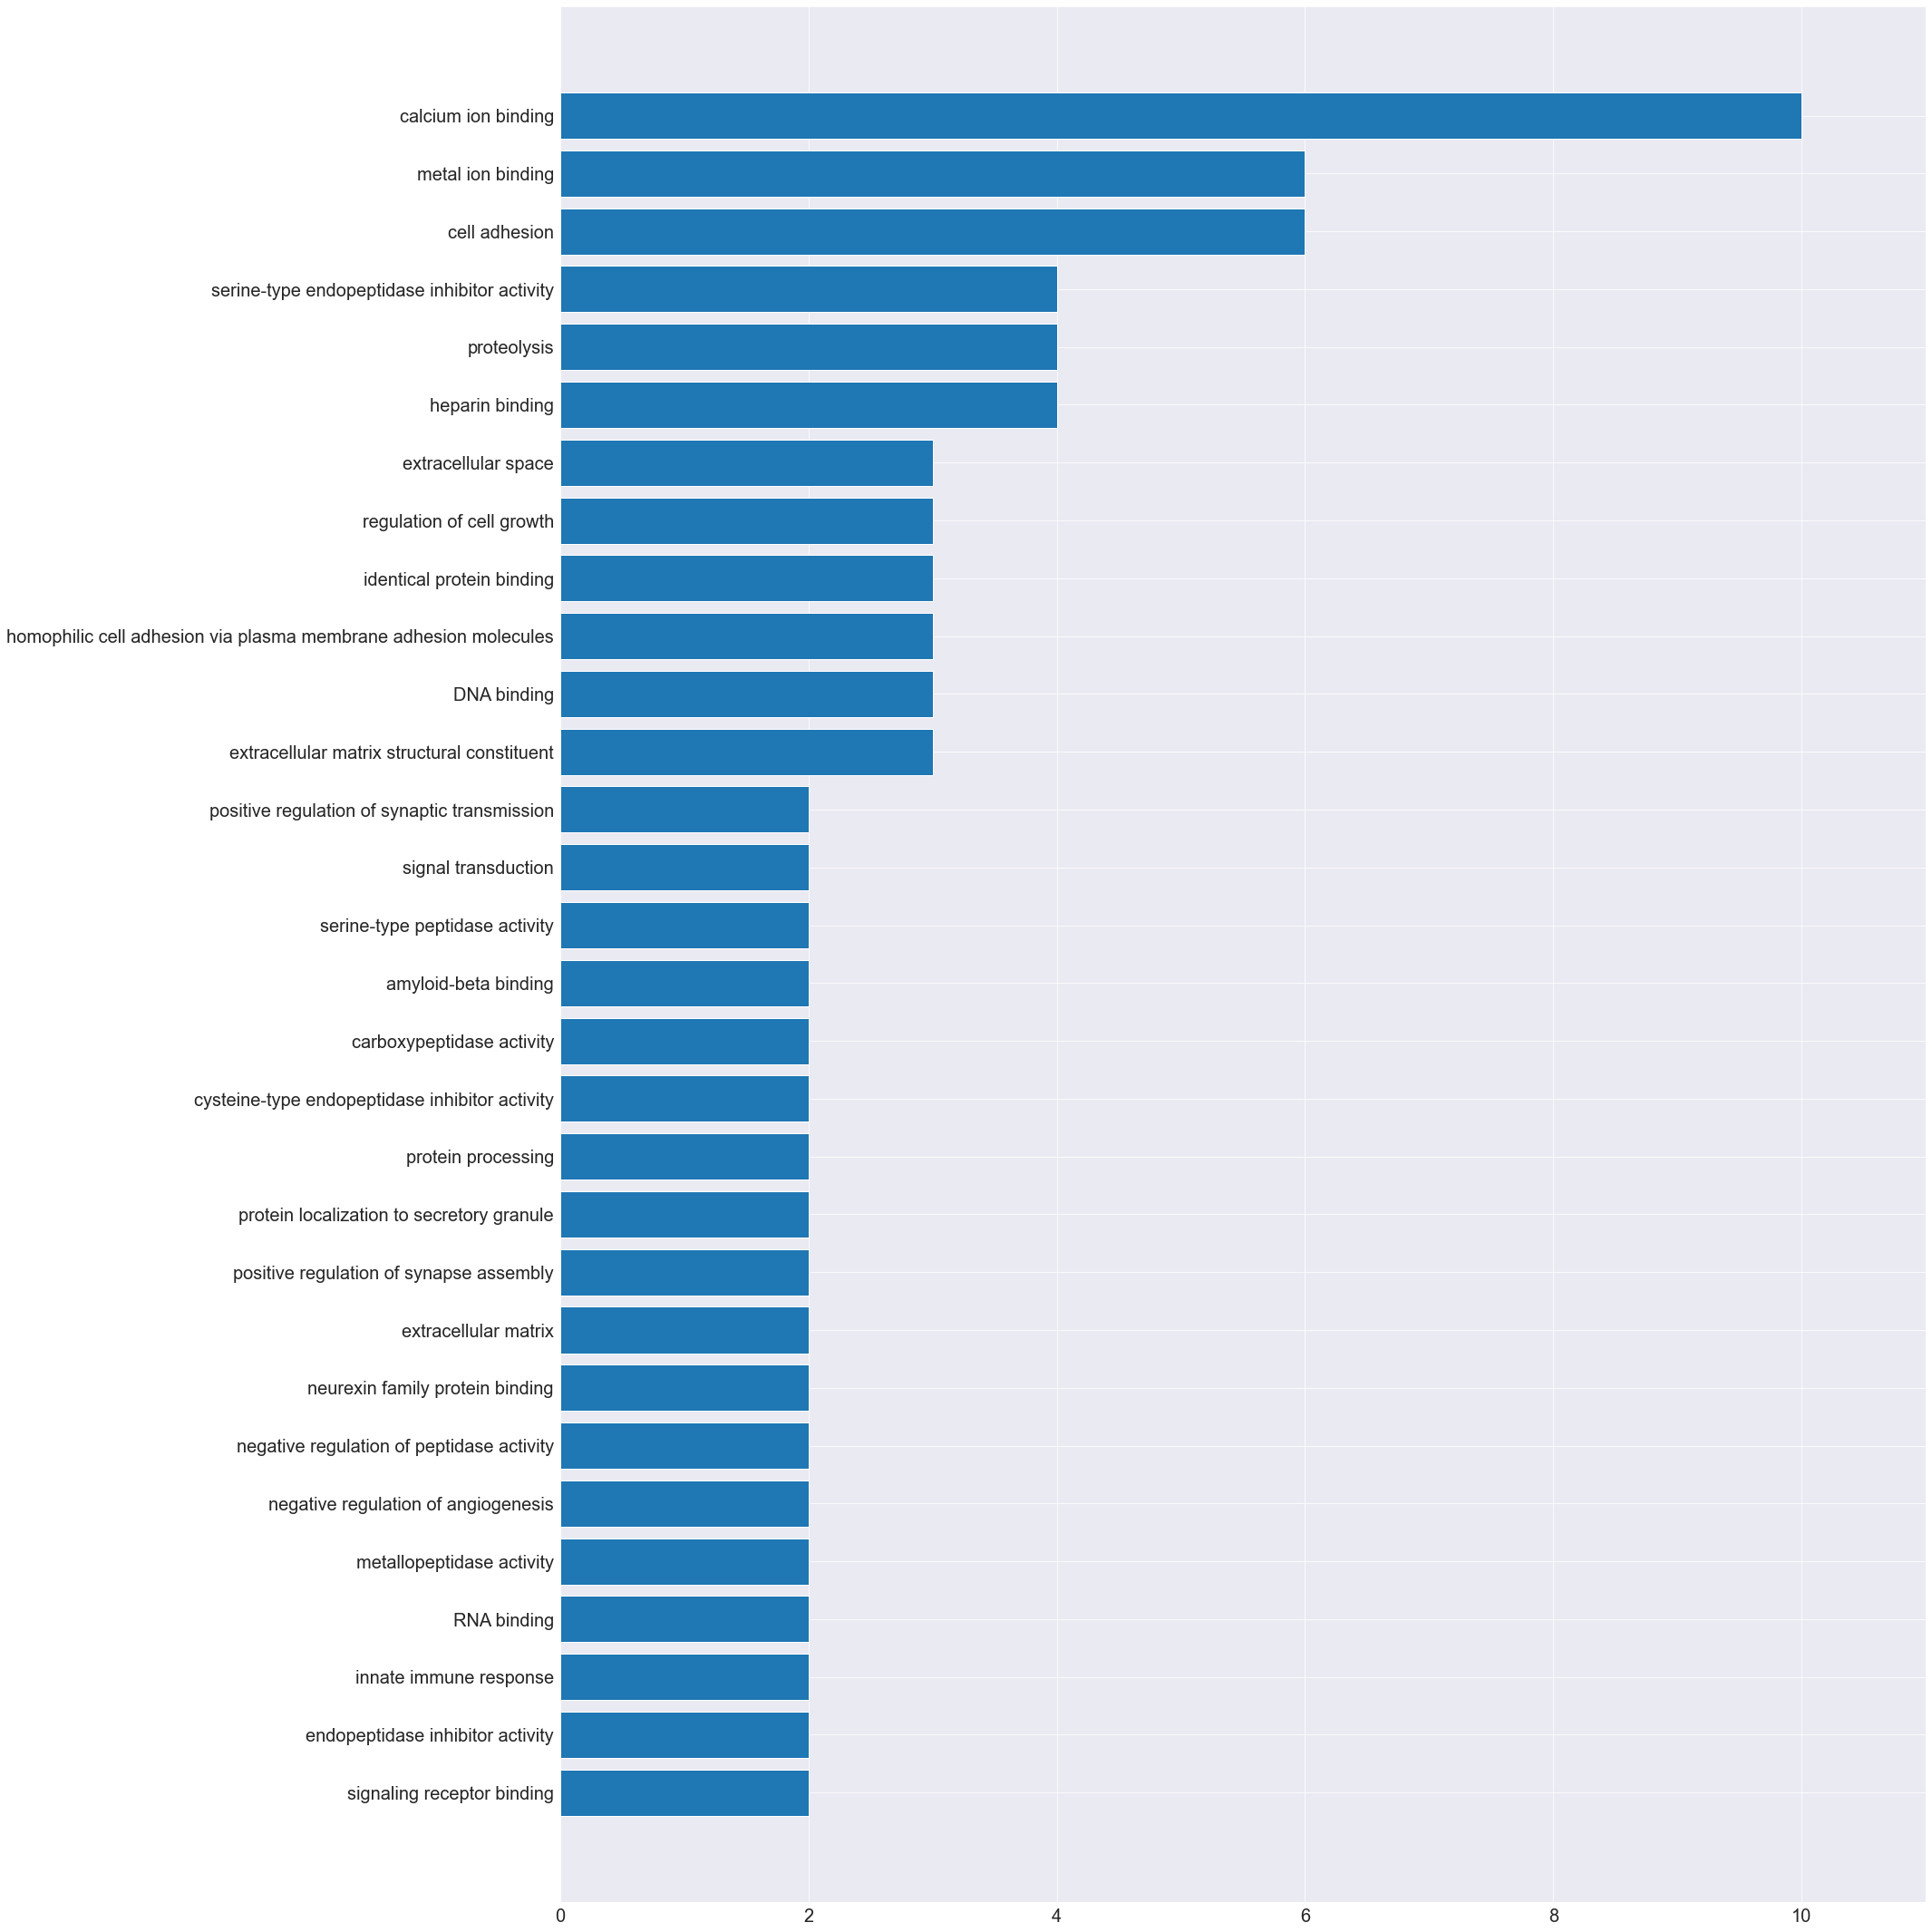

In [24]:
# Plot all protein functions

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

functions_positive = protein_DGC_function_df[
    # (protein_DGC_function_df['qualifier'] == 'involved_in') &
    (protein_DGC_function_df['qualifier'] != 'NOT|enables') &
    (protein_DGC_function_df['qualifier'] != 'NOT|involved_in') &
    (protein_DGC_function_df['qualifier'] != 'located_in') &
    (protein_DGC_function_df['qualifier'] != 'colocalizes_with') &
    (protein_DGC_function_df['function.name'] != 'protein binding') &
    (protein_DGC_function_df['lm1.groupDGC.coef'] > 0)
].groupby('function.name')['id.name'].nunique()

# For functions with negative coefficients
functions_negative = protein_DGC_function_df[
    # (protein_DGC_function_df['qualifier'] == 'involved_in') &
    (protein_DGC_function_df['qualifier'] != 'NOT|enables') &
    (protein_DGC_function_df['qualifier'] != 'NOT|involved_in') &
    (protein_DGC_function_df['qualifier'] != 'located_in') &
    (protein_DGC_function_df['qualifier'] != 'colocalizes_with') &
    (protein_DGC_function_df['function.name'] != 'protein binding') &
    (protein_DGC_function_df['lm1.groupDGC.coef'] < 0)
].groupby('function.name')['id.name'].nunique()

# Convert the Series to DataFrame for easier manipulation and renaming
functions_positive_df = functions_positive.reset_index(name='unique_proteins_count')
functions_positive_df.columns = ['function.name', 'count']
functions_negative_df = functions_negative.reset_index(name='unique_proteins_count')
functions_negative_df.columns = ['function.name', 'count']

functions_positive_df = functions_positive_df[functions_positive_df['count'] > 1].sort_values('count',ascending=False)
functions_negative_df = functions_negative_df[functions_negative_df['count'] > 1].sort_values('count',ascending=False)

length = len(functions_positive_df)

max_length = len(functions_positive_df)

dynamic_scalar = max_length / 1

x = functions_positive_df['function.name']
y = functions_positive_df['count']

xmax = 11

fig, ax = plt.subplots(figsize=(figwidth,dynamic_scalar))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([0,xmax])
ax.barh(x, width = y)
ax.invert_yaxis()
plt.savefig('function_dgc_g0.png')
plt.show()

length = len(functions_negative_df)

max_length = len(functions_negative_df)

dynamic_scalar = max_length / 1

x = functions_negative_df['function.name']
y = functions_negative_df['count']

fig, ax = plt.subplots(figsize=(figwidth,dynamic_scalar))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlim([0,xmax])
ax.barh(x, width = y)
ax.invert_yaxis()
plt.savefig('function_dgc_l0.png')
plt.show()

In [25]:
indices = range(1, len(diffexp_newmodel_df) + 1)
diffexp_newmodel_df.to_excel('diffexp_newmodel.xlsx', index=False)